In [1]:
import sys
sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime
from scipy import stats
from scipy import optimize
from scipy.optimize import minimize

# typehints
from typing import Union, List, Tuple

"""
Own packages
"""

from codelib.statistics.moments import corr_to_cov_matrix

from codelib.portfolio_optimization.mean_variance import portfolio_mean, portfolio_std, portfolio_variance

from codelib.visualization.layout import DefaultStyle, default_colors
DefaultStyle();

from codelib.visualization.base import risk_waterfall_chart

# The Black-Litterman model 

The [Black-Litterman model](https://en.wikipedia.org/wiki/Black%E2%80%93Litterman_model) is a commonly applied extension to the traditional Markowitz approach. 


Our presentation of the Black-Litterman model (BL) will follow primarily [Meucci (2008)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1117574), but see also [Riccardo Rebonato and Alexander Denev, "Portfolio Management under stress"](https://www.amazon.com/Portfolio-Management-under-Stress-Bayesian-Net/dp/1107048117) and [Ignazio Basile and Pierpaolo Ferrari (2016), "Asset Management and Institutional Investors"](https://link.springer.com/book/10.1007/978-3-319-32796-9). 


## The original formulation 

### The market model 

We assume that the vector of returns ($N \times 1$) follows a normal distribution 

$$
\mathbf{R} \sim N(\boldsymbol{\mu}, \boldsymbol{\Sigma})
$$

where $\boldsymbol{\Sigma}$ is estimated based on e.g. exponential smoothing. As previously discussed, the estimation error of the expected returns (sample mean) can be very large and an important culprit for the failure of traditional Markowitz mean-variance optimization. BL assumes that the expected return vector follows the distribution 

$$
\boldsymbol{\mu} \sim N(\boldsymbol{\pi}, \tau \boldsymbol{\Sigma})
$$

where $\boldsymbol{\pi}$ represents the best view of $\boldsymbol{\mu}$ and $\tau \boldsymbol{\Sigma}$ represents the uncertainty which is assumed to be proportional to the return variance. 

__The equilibrium argument: Finding the expected returns__

We assume that all investors maximize a mean-variance trade-off and that the optimization is unconstrained:

$$
\text{arg max } U(\mathbf{w})  = \text{arg max } \mathbf{w}^\top \boldsymbol{\pi} - \frac{\lambda}{2} \mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}
$$

where the first order conditions are given by

$$
\left. \frac{\partial U(\mathbf{w})}{\partial \mathbf{w}} \right \vert_{\mathbf{w}= \mathbf{w}^*} = \boldsymbol{\pi} - \lambda \boldsymbol{\Sigma} \mathbf{w}^* = \mathbf{0}
$$

In stead of solving for the optimal weights, we solve for the expected return given the market (or equilibrium) portfolio weights $\mathbf{w}_m$

$$
\boldsymbol{\pi} = \lambda \boldsymbol{\Sigma} \mathbf{w}_m
$$

Setting $\lambda$ will then give us the expected return vector. How should we set $\lambda$? One possibility is the consider the CAPM world where the expected return can be written as

$$
\boldsymbol{\pi} = \mathbf{\beta} \left[\mu_{m} - r_f \right]
$$

where 

$$
\mathbf{\beta} = \frac{\text{Cov}[\mathbf{R}, \mathbf{w}_m^\top \mathbf{R}]}{\text{Var}[\mathbf{w}_m^\top \mathbf{R}]} = \frac{\text{Cov}[\mathbf{R}, \mathbf{w}_m^\top \mathbf{R}]}{\sigma^2_m}
$$

Inserting this in the above equation yields

$$
\boldsymbol{\pi} = \frac{\text{Cov}[\mathbf{R}, \mathbf{w}_m^\top \mathbf{R}]}{\sigma^2_m} \left[\mu_{m} - r_f \right] = \lambda \boldsymbol{\Sigma} \mathbf{w}_m
$$

Thus, we can set $\lambda = \left[\mu_{m} - r_f \right] / \sigma^2_m$  consistent with the CAPM. Note that 

$$
\text{Cov}[\mathbf{R}, \mathbf{w}_m^\top \mathbf{R}] = \text{Cov}[\mathbf{R}, \mathbf{R}] \mathbf{w}_m = \boldsymbol{\Sigma} \mathbf{w}_m
$$

We can think of this expected return estimator as a type of shrinkage estimator. The sample mean is given by 

$$
\hat{\boldsymbol{\mu}} = \frac{1}{T} \sum_{t=1}^T \mathbf{R}_t \sim N\left(\boldsymbol{\pi}, \frac{1}{T} \boldsymbol{\Sigma}\right)
$$

which is a very inefficient estimator. The Stein-type shrinkage estimator is given by

$$
\hat{\boldsymbol{\mu}}^s = (1-s) \hat{\boldsymbol{\mu}} + s\boldsymbol{\pi}^0, \; s \in [0, 1]
$$

where $s$ is the amount of shrinkage. Thus, we can think of the above BL estimator as complete shrinkage towards the equilibrium value. 


__Specifying the uncertainty__

The distribution of the expected return vector

$$
\boldsymbol{\mu} \sim N(\boldsymbol{\pi}, \tau \boldsymbol{\Sigma})
$$

depends on $\tau$ which we can think of as the confidence in the the expected return estimate (close to zero means large confidence). If we compare with the sample mean then 

$$
\tau \approx \frac{1}{T}
$$

could be a reasonable value. However, different choices are used. Typically, $\tau \in (0, 1]$

__Example__

See [Meucci (2008), "The Black-Litterman Approach: Original Model and Extensions"](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1117574). 

Assume that the six stock indices for Italy, Switerland, Canada, US and Germany can be described by the volatility vector (annualized) $\boldsymbol{\sigma} = [21\%, 24\%, 24\% 25\%, 20\%, 31\%]^\top$ and the correlation matrix 

$$
\mathbf{C} = \begin{bmatrix}
1 & 54\% & 62\% & 25\% & 41\% & 59\% \\
& 1 & 69\% & 29\% & 36\% & 83\% \\
& & 1 & 15\% & 46\% &  65\% \\
&&& 1 & 47\% & 39\% \\
&&&& 1 & 38\% \\
&&&&& 1
\end{bmatrix}
$$

Assume that $\mathbf{w}_m = [4\%, 4\%, 8\%, 71\%, 8\%]^\top$. What is the implied expected returns when assuming $\lambda = 2.4$?

In [2]:
corr_mat = np.array([[1.0, 0.54, 0.62, 0.25, 0.41, 0.59],
                     [0.54, 1.0, 0.69, 0.29, 0.36, 0.83],
                     [0.62, 0.69, 1.0, 0.15, 0.46, 0.65],
                     [0.25, 0.29, 0.15, 1.0, 0.47, 0.39],
                     [0.41, 0.36, 0.46, 0.47, 1.0, 0.38],
                     [0.59, 0.83, 0.65, 0.39, 0.38, 1]])

vols = np.array([0.21, 0.24, 0.24, 0.25, 0.29, 0.31])

w_m = np.array([0.04, 0.04, 0.05, 0.08, 0.71, 0.08])

cov_mat = corr_to_cov_matrix(corr_mat, vols)

In [3]:
def calculate_capm_expected_return(cov_mat: np.ndarray, w_m: np.ndarray, lam: float) -> np.ndarray:
    """
    Calculates the equilibrium return for the market model. 
    
    Parameters
    ----------
    cov_mat: 
        Covariance matrix of returns. 
    w_m: 
        Market cap weights. 
    lam
        Risk aversion parameters. We can think of it as the excess return of the market divided by its variance. 

    Returns
    -------
    np.ndarray
        Expected returns implied by the market model. 

    """

    return lam * cov_mat @ w_m

In [4]:
pi = calculate_capm_expected_return(cov_mat, w_m, 2.4)
pi

array([0.0630378 , 0.07080422, 0.07929562, 0.0798774 , 0.16505222,
       0.0978851 ])

### The views 

We can think of a view as a statemant regarding the market which may potentially clash with the reference market model (defined above). 

We can define $K$ linear views using a "pick" matrix $\mathbf{P}$ ($K \times N$) with some assumed uncertainty which in the BL case is represented by the normal distribution

$$
\mathbf{P} \boldsymbol{\mu} \sim N(\mathbf{v}, \boldsymbol{\Omega})
$$

One convenient way of setting the uncertainty is to use the market volatilities and correlations

$$
\boldsymbol{\Omega} = \frac{1}{c} \mathbf{P}\boldsymbol{\Sigma} \mathbf{P}^\top
$$

where $c \in (0, \infty)$ represents the overall level of confidence with the views. Alternatively, a scale-independent, relative uncertainty level to the different views can be specified as 

$$
\boldsymbol{\Omega} = \frac{1}{c} \text{diag} (\mathbf{u}) \mathbf{P}\boldsymbol{\Sigma} \mathbf{P}^\top \text{diag}( \mathbf{u})
$$

with $\mathbf{u}\in (0, \infty)^K$

__Example__

See [Meucci (2008), "The Black-Litterman Approach: Original Model and Extensions"](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1117574). 

The pick matrix 

$$
\mathbf{P} = \begin{bmatrix} 0 & 1 & 0 & 0 & 0 & 0 \\ 0 & 0& 0& 0 & 1 & -1 \end{bmatrix}
$$

with $\mathbf{v} = [0.12, -0.1]$ corresponds to the views that the Spanish Index will increase by 12% (annualized) and that Germany will outperform US with 10%. If we set $c=1$, then the magnitude of the view is of the same order as the market.

### The posterior 

[Meucci (2008), "The Black-Litterman Approach: Original Model and Extensions"](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1117574) shows that the distribution of $\boldsymbol{\mu}$ given the views can be specified as 

$$
\boldsymbol{\mu} \vert \mathbf{v}; \boldsymbol{\Omega} \sim N(\boldsymbol{\mu}_{BL}, \boldsymbol{\Sigma}_{BL}^{\mu})
$$

with 

$$
\boldsymbol{\mu}_{BL} = \left((\tau \boldsymbol{\Sigma})^{-1} + \mathbf{P}^\top \mathbf{\Omega} \mathbf{P} \right)^{-1} \left((\tau \boldsymbol{\Sigma})^{-1} \boldsymbol{\pi} + \mathbf{P}^\top \mathbf{\Omega}^{-1} \mathbf{v} \right)
$$

and 

$$
\boldsymbol{\Sigma}_{BL}^\mu =  \left((\tau \boldsymbol{\Sigma})^{-1} + \mathbf{P}^\top \mathbf{\Omega} \mathbf{P} \right)^{-1} 
$$

We are, however, interested in the distribution of the returns $\mathbf{R}$ (or it could also be some other market invariants). To that end, we write 

$$
\mathbf{R} = \boldsymbol{\mu} + \mathbf{Z}
$$

where $\mathbf{Z} \sim N(0, \boldsymbol{\Sigma})$. Therefore, 


$$
\mathbf{R} \vert \mathbf{v}; \boldsymbol{\Omega} \sim N(\boldsymbol{\mu}_{BL}, \boldsymbol{\Sigma}_{BL})
$$

where (assuming that $\boldsymbol{\mu}$ and $\mathbf{Z}$ are independent)

$$
\boldsymbol{\Sigma}_{BL} = \boldsymbol{\Sigma} + \boldsymbol{\Sigma}_{BL}^\mu
$$

[Meucci (2008), "The Black-Litterman Approach: Original Model and Extensions"](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1117574) presents the computationally more stable solution

\begin{align}
 \boldsymbol{\mu}_{BL}&= \boldsymbol{\pi} + \tau \boldsymbol{\Sigma} \mathbf{P}^\top \left(\tau \mathbf{P}   \boldsymbol{\Sigma} \mathbf{P}^\top  +  \boldsymbol{\Omega} \right)^{-1} (\mathbf{v} - \mathbf{P} \boldsymbol{\pi} )\\
\boldsymbol{\Sigma}_{BL} &= (1+\tau)  \boldsymbol{\Sigma} - \tau^2  \boldsymbol{\Sigma} \mathbf{P}^\top \left(\tau \mathbf{P}   \boldsymbol{\Sigma} \mathbf{P}^\top  +  \boldsymbol{\Omega} \right)^{-1} \mathbf{P} \boldsymbol{\Sigma}
\end{align}


__Example__

Consider the information given in the previous examples. Assume that $\tau = 0.6$. Implement the long-only optimal portfolio, i.e. $\mathbf{w} \geq \mathbf{0}$ and $\mathbf{w}^\top \mathbf{1} = 1$. 

We should see an increasing allocation to Spain (at least for low target returns) and the exposure to Germany should increase for all target returns. 

In [5]:
def calculate_bl_mu(pi: float, tau: float, cov_mat: np.ndarray, view_mat: np.ndarray,
                    view_vec: np.ndarray, view_cov_mat: np.ndarray=None, confidence: float=1.0) -> np.ndarray:

    """
    Calculates the posterior expected returns in the Black-Litterman model

    Parameters
    ----------
    pi:
        The expected return from the market model.
    tau:
        Parameter that scales the covariance matrix. The smaller, the less uncertainty. 
    cov_mat: 
        The covariance matrix of the market model. 
    view_mat: 
        The "pick" matrix which defines the views. 
    view_vec: 
        The vector that defines the views. 
    view_cov_mat: 
        Covariance matrix of the views (prior). If None, then it is calculated by the formula suggested
        by Meucci (2008)
    confidence:
        The confidence level. Only necessary if view_cov_mat is not provided. 

    Returns
    -------
    np.ndarray
        The posterior expected value. 

    """

    if view_cov_mat is None:
        view_cov_mat = (view_mat @ cov_mat @ view_mat.T) / confidence
        
    part_2 = np.linalg.inv(tau * view_mat @ cov_mat @ view_mat.T + view_cov_mat)
    part_3 = view_vec - view_mat @ pi 
    
    mu_bl = pi + tau * cov_mat @ view_mat.T @ part_2 @ part_3

    return mu_bl


def calculate_bl_sigma(tau: float, cov_mat: np.ndarray, view_mat: np.ndarray, view_cov_mat: np.ndarray = None,
                       confidence: float = 1.0) -> np.ndarray:
    """
    Calculates the posterior covariance matrix in the Black-Litterman model

    Parameters
    ----------
    tau:
        Parameter that scales the covariance matrix. The smaller, the less uncertainty.
    cov_mat:
        The covariance matrix of the market model.
    view_mat:
        The "pick" matrix which defines the views.
    view_cov_mat:
        Covariance matrix of the views (prior). If None, then it is calculated by the formula suggested
        by Meucci (2008)
    confidence:
        The confidence level. Only necessary if view_cov_mat is not provided.

    Returns
    -------
    np.ndarray
        The posterior covariance matrix.

    """

    if view_cov_mat is None:
        view_cov_mat = (view_mat @ cov_mat @ view_mat.T) / confidence
    
    part_1 = (1 + tau) * cov_mat
    part_2 = np.linalg.inv(tau * view_mat @ cov_mat @ view_mat.T + view_cov_mat)

    sigma_bl = part_1 - tau**2 * cov_mat @ view_mat.T @ part_2 @ view_mat @ cov_mat 

    return sigma_bl

In [6]:
def calculate_optimal_weights(cov_mat, mu, target_return): 
    
    num_assets = len(cov_mat)
    a_matrix = np.zeros((num_assets + 2, num_assets + 2))
    a_matrix[:num_assets, :num_assets] = 2 * cov_mat
    a_matrix[num_assets, :num_assets] = a_matrix[:num_assets, num_assets] = mu
    a_matrix[num_assets + 1, :num_assets] = a_matrix[:num_assets, num_assets + 1] =  1.0
    
    b_vector = np.zeros(num_assets + 2)
    b_vector[-2] = target_return
    b_vector[-1] = 1.0

    x = np.linalg.inv(a_matrix) @ b_vector
    
    return x[:-2]

In [7]:
tau = 0.6

# pick matrix
view_mat = np.zeros((2, 6))
view_mat[0, 1] = view_mat[1, 4] = 1
view_mat[1, 5] = -1

# view vector
view_vec = np.array([0.12, -0.1])

mu_bl = calculate_bl_mu(pi, tau, cov_mat, view_mat, view_vec, view_cov_mat=None, confidence=1.0)
cov_mat_bl = calculate_bl_sigma(tau, cov_mat, view_mat, view_cov_mat=None, confidence=1.0)

In [8]:
# define common constraints 
sum_to_one_cons = {'type': 'eq',
                   'fun' : lambda x: np.sum(x) - 1.0, 
                   'jac' : lambda x: np.ones_like(x)}

no_short_cons = {'type': 'ineq',
                 'fun' : lambda x: x,
                 'jac' : lambda x: np.eye(len(x))}

# alternatively use 
bounds = [(0.0, 1.0)] * len(pi)

# set target returns
target_returns = np.linspace(0.075, 0.13, 50)

optimal_port_weights_1 = []
optimal_port_weights_2 = []

x0 = np.ones_like(pi) / len(pi)

for target_return in target_returns: 
    
    # define constraint 
    target_cons = {'type': 'eq',
                   'fun' : lambda x: x @ pi - target_return,
                   'jac' : lambda x: pi}
    
    res = optimize.minimize(portfolio_variance, x0=x0, args=(cov_mat,),
                            method='SLSQP',
                            constraints=[sum_to_one_cons, no_short_cons,  target_cons],  # no_short_cons,
                            options={'ftol': 1e-9, 'disp': False}) #, bounds=bounds)

    optimal_port_weights_1.append(res.x)
    
    # define constraint 
    target_cons = {'type': 'eq',
                   'fun' : lambda x: x @ mu_bl - target_return,
                   'jac' : lambda x: mu_bl}
    
    res = optimize.minimize(portfolio_variance, x0=x0, args=(cov_mat_bl,),
                            method='SLSQP',
                            constraints=[sum_to_one_cons, no_short_cons,  target_cons],  # no_short_cons,
                            options={'ftol': 1e-9, 'disp': False}) #, bounds=bounds)

    optimal_port_weights_2.append(res.x)
    

optimal_port_weights_1 = np.array(optimal_port_weights_1)
optimal_port_weights_2 = np.array(optimal_port_weights_2)

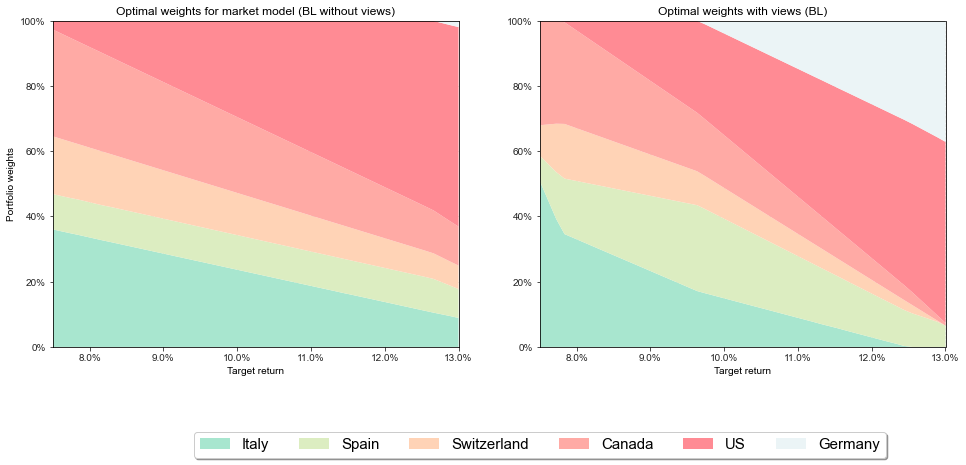

In [9]:
asset_names = ["Italy", "Spain", "Switzerland", "Canada", "US", "Germany"]
fig, ax = plt.subplots(1, 2, figsize=(16, 6))


ax[0].stackplot(target_returns, optimal_port_weights_1.T, labels=asset_names);
ax[0].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))
ax[0].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax[0].set_xlabel("Target return")
ax[0].set_ylabel("Portfolio weights")
ax[0].set_title("Optimal weights for market model (BL without views)")
#ax[0].legend(loc='center', bbox_to_anchor=(0.5, -0.3),
#          fancybox=True, shadow=True, ncol=6);

ax[1].stackplot(target_returns, optimal_port_weights_2.T, labels=asset_names);
ax[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))
ax[1].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax[1].set_xlabel("Target return")
#ax[1].set_ylabel("Portfolio weights")
ax[1].set_title("Optimal weights with views (BL)");
ax[1].legend(loc='center', bbox_to_anchor=(0.0, -0.3),
          fancybox=True, shadow=True, ncol=6);

## Some puzzles  and the market formulation

### Uniformative views

If the views are uninformative, i.e. $"\boldsymbol{\Omega} \to \infty"$, then we would probably expect that 

$$
\mathbf{R} \sim N(\pi, \boldsymbol{\Sigma})
$$

such that we obtain the "market model". However, this is not the case. In fact

$$
\mathbf{R} \sim N(\pi, (1 + \tau)\boldsymbol{\Sigma})
$$

Thus, the distribution is distorted (if $\tau \neq 0$). This is a consequence of that we obtained the reference distribution by assuming no estimation risk. 

### Full confidence views

If the views are very informative, i.e. $"\boldsymbol{\Omega} \to 0"$, then we would probably expect the posterior to be the market model conditioned on the specific views, i.e. 

$$
\mathbf{R} \vert \mathbf{v} \sim N(\boldsymbol{\mu} \vert \mathbf{v}, \boldsymbol{\Sigma} \vert \mathbf{v})
$$

where 

\begin{align}
\boldsymbol{\mu} \vert \mathbf{v} &=  \boldsymbol{\pi} + \boldsymbol{\Sigma} \mathbf{P}^\top \left(\mathbf{P}   \boldsymbol{\Sigma} \mathbf{P}^\top \right)^{-1} (\mathbf{v} - \mathbf{P} \boldsymbol{\pi} ) \\
\boldsymbol{\Sigma} \vert \mathbf{v} &= \boldsymbol{\Sigma} - \boldsymbol{\Sigma} \mathbf{P}^\top \left(\mathbf{P}   \boldsymbol{\Sigma} \mathbf{P}^\top\right)^{-1} \mathbf{P} \boldsymbol{\Sigma}
\end{align}

However, this is not the case for the Black-Litterman model:

$$
\mathbf{R}  \sim N(\boldsymbol{\mu}_{BL}^{\boldsymbol{\Omega}=0}, \boldsymbol{\Sigma}^{\boldsymbol{\Omega}=0}_{BL})
$$
with

\begin{align}
 \boldsymbol{\mu}_{BL}^{\boldsymbol{\Omega}=0}&= \boldsymbol{\pi} +  \boldsymbol{\Sigma} \mathbf{P}^\top \left( \mathbf{P}   \boldsymbol{\Sigma} \mathbf{P}^\top \right)^{-1} (\mathbf{v} - \mathbf{P} \boldsymbol{\pi} )\\
\boldsymbol{\Sigma}_{BL}^{\boldsymbol{\Omega}=0} &= (1+\tau)  \boldsymbol{\Sigma} - \tau^2  \boldsymbol{\Sigma} \mathbf{P}^\top \left(\tau \mathbf{P}   \boldsymbol{\Sigma} \mathbf{P}^\top \right)^{-1} \mathbf{P} \boldsymbol{\Sigma}
\end{align}

The expectation is the same, but not the covariance. Again, this is due to specifying the views on $\boldsymbol{\mu}$ and not directly on $\mathbf{R}$. 


### The market formulation 

[Meucci (2008), "The Black-Litterman Approach: Original Model and Extensions"](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1117574) suggests to simply set $\boldsymbol{\mu} = \boldsymbol{\pi}$ such that it is not a random variable and express our views directly on $\mathbf{R}$ using $\mathbf{P} \mathbf{R} = \mathbf{V}$ where we can think of the views as a random variable $\mathbf{V}$ with the conditional distribution 

$$
\mathbf{V} \vert \mathbf{r} \sim N(\mathbf{Pr}, \boldsymbol{\Omega})
$$

In practice, we will choose a specific value of $\mathbf{v}$. It is possible to show that 

$$
\mathbf{R} \vert \mathbf{v}, \boldsymbol{\Omega} \sim N(\boldsymbol{\mu}_{BL}^m, \boldsymbol{\Sigma}_{BL}^m)
$$

where 

\begin{align}
\boldsymbol{\mu}_{BL}^m &=  \boldsymbol{\pi} + \boldsymbol{\Sigma} \mathbf{P}^\top \left(\mathbf{P}   \boldsymbol{\Sigma} \mathbf{P}^\top + \boldsymbol{\Omega}\right)^{-1} (\mathbf{v} - \mathbf{P} \boldsymbol{\pi} ) \\
\boldsymbol{\Sigma}_{BL}^m &= \boldsymbol{\Sigma} - \boldsymbol{\Sigma} \mathbf{P}^\top \left(\mathbf{P}   \boldsymbol{\Sigma} \mathbf{P}^\top + \boldsymbol{\Omega} \right)^{-1} \mathbf{P} \boldsymbol{\Sigma}
\end{align}

# References

## Articles

[Meucci (2008), "The Black-Litterman Approach: Original Model and Extensions"](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1117574)


## Books

[Riccardo Rebonato and Alexander Denev, "Portfolio Management under stress"](https://www.amazon.com/Portfolio-Management-under-Stress-Bayesian-Net/dp/1107048117)

[Ignazio Basile and Pierpaolo Ferrari (2016), "Asset Management and Institutional Investors"](https://link.springer.com/book/10.1007/978-3-319-32796-9)

[Marcos M. Lopéz de Prado (2020), "Machine Learning for Asset Managers"](https://www.amazon.com/Machine-Learning-Managers-Elements-Quantitative/dp/1108792898)

